##Simple NN for Image Classification

## Preparing the Data



In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

We download the data and create a PyTorch dataset using the `MNIST` class from `torchvision.datasets`.

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Next, let's use the `random_split` helper function to set aside 10000 images for our validation set.

In [3]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create PyTorch data loaders for training and validation.

In [4]:
batch_size=128

In [5]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)


Let's visualize a batch of data in a grid using the `make_grid` function from `torchvision`. We'll also use the `.permute` method on the tensor to move the channels to the last dimension, as expected by `matplotlib`.


images.shape: torch.Size([128, 1, 28, 28])


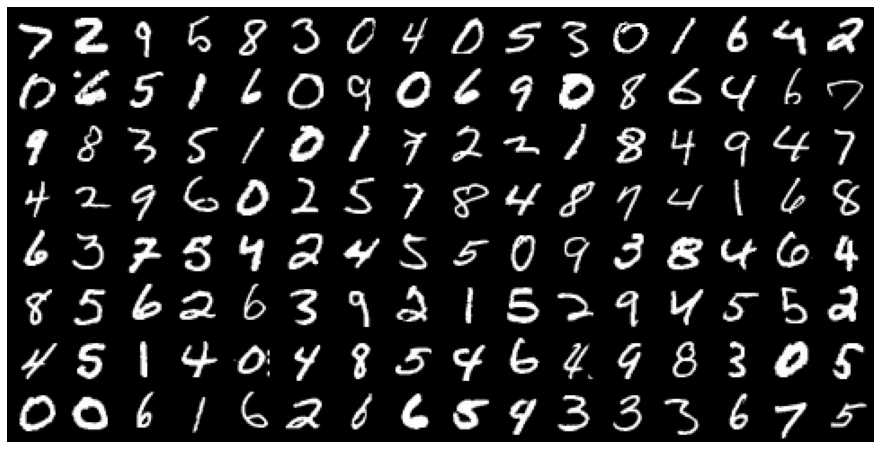

In [6]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [8]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

We'll create a model that contains a hidden layer with 32 activations.

In [9]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [10]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

Let's take a look at the model's parameters. We expect to see one weight and bias matrix for each of the layers.

In [11]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Let's try and generate some outputs using our model. We'll take the first batch of 128 images from our dataset, and pass them into our model.

In [12]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3109498023986816
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.1450, -0.0179, -0.1596,  0.2283,  0.0041, -0.2306,  0.0084, -0.0928,
          0.0164,  0.2918],
        [-0.1457, -0.0711, -0.1072,  0.1262,  0.1284, -0.1733,  0.0561, -0.0393,
         -0.0106,  0.1198]])


## Using a GPU

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores that are optimized for performing expensive matrix operations on floating point numbers in a short time, which makes them ideal for training deep neural networks with many layers. You can use GPUs for free on [Kaggle kernels](https://www.kaggle.com/kernels) or [Google Colab](https://colab.research.google.com/), or rent GPU-powered machines on services like [Google Cloud Platform](https://cloud.google.com/gpu/), [Amazon Web Services](https://docs.aws.amazon.com/dlami/latest/devguide/gpu.html) or [Paperspace](https://www.paperspace.com/).

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using `torch.cuda.is_available`.

In [13]:
torch.cuda.is_available()

True

Let's define a helper function to ensure that our code uses the GPU if available, and defaults to using the CPU if it isn't.

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [15]:
device = get_default_device()
device

device(type='cuda')

Next, let's define a function that can move data and model to a chosen device.

In [16]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [17]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move data to the selected device, as a batches are accessed. Interestingly, we don't need to extend an existing class to create a PyTorch dataloader. All we need is an `__iter__` method to retrieve batches of data, and an `__len__` method to get the number of batches.

In [18]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

We can now wrap our data loaders using `DeviceDataLoader`.

In [19]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Tensors that have been moved to the GPU's RAM have a `device` property which includes the word `cuda`. Let's verify this by looking at a batch of data from `valid_dl`.

In [20]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([5, 0, 5, 4, 2, 2, 7, 6, 7, 2, 6, 1, 5, 7, 1, 3, 6, 2, 7, 4, 6, 7, 0, 4,
        4, 0, 4, 3, 6, 1, 9, 7, 3, 5, 5, 7, 9, 0, 4, 6, 8, 9, 5, 6, 0, 9, 7, 4,
        1, 3, 2, 9, 7, 6, 9, 0, 1, 1, 8, 6, 7, 1, 4, 9, 9, 4, 5, 9, 3, 0, 1, 2,
        9, 9, 0, 1, 4, 2, 4, 3, 2, 0, 2, 1, 0, 3, 0, 5, 4, 6, 3, 4, 3, 0, 2, 7,
        9, 6, 4, 2, 1, 1, 1, 9, 2, 9, 7, 7, 2, 5, 9, 5, 9, 5, 5, 5, 8, 6, 3, 6,
        7, 2, 8, 4, 5, 1, 5, 1, 6, 7, 2, 7, 3, 3, 0, 5, 6, 1, 3, 2, 4, 3, 4, 6,
        9, 0, 5, 7, 3, 0, 0, 3, 7, 0, 3, 2, 8, 5, 1, 9, 7, 0, 8, 2, 7, 3, 4, 0,
        5, 7, 5, 7, 7, 8, 7, 0, 3, 1, 1, 4, 5, 7, 5, 7, 8, 0, 5, 8, 3, 1, 3, 6,
        2, 5, 6, 2, 8, 5, 8, 3, 0, 0, 7, 4, 6, 9, 8, 5, 5, 4, 8, 8, 1, 8, 1, 4,
        5, 7, 6, 3, 5, 1, 3, 4, 1, 6, 8, 3, 3, 2, 8, 6, 1, 5, 9, 7, 8, 1, 9, 3,
        8, 4, 6, 9, 1, 1, 1, 8, 4, 2, 3, 0, 8, 5, 3, 0], device='cuda:0')


## Training the Model

We can use the exact same training loops from the logistic regression notebook.

In [21]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

We also define an `accuracy` function which calculates the overall accuracy of the model on an entire batch of outputs, so that we can use it as a metric in `fit`.

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the `to_device` function to move the model's parameters to the right device. 

In [22]:
# Model (on GPU)

model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

Let's see how the model performs on the validation set with the initial set of weights and biases.

In [23]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.11416015774011612, 'val_loss': 2.323023796081543}]

The initial accuracy is around 10%, which is what one might expect from a randomly intialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

We are now ready to train the model. Let's train for 5 epochs and look at the results. We can use a relatively higher learning of 0.5.

In [24]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2363, val_acc: 0.9274
Epoch [1], val_loss: 0.3732, val_acc: 0.8781
Epoch [2], val_loss: 0.2187, val_acc: 0.9348
Epoch [3], val_loss: 0.1632, val_acc: 0.9517
Epoch [4], val_loss: 0.1479, val_acc: 0.9546


96% is pretty good! Let's train the model for 5 more epochs at a lower learning rate of 0.1, to further improve the accuracy.

In [25]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1189, val_acc: 0.9641
Epoch [1], val_loss: 0.1186, val_acc: 0.9649
Epoch [2], val_loss: 0.1181, val_acc: 0.9653
Epoch [3], val_loss: 0.1164, val_acc: 0.9657
Epoch [4], val_loss: 0.1167, val_acc: 0.9656


We can now plot the losses & accuracies to study how the model improves over time.

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

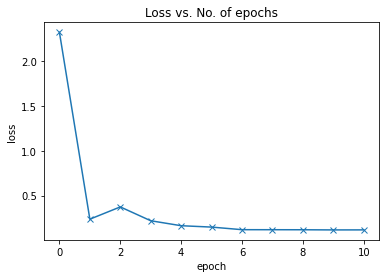

In [27]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

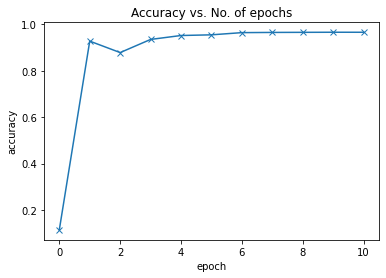

In [28]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Our current model quickly reaches an accuracy of 97%, but doesn't improve much beyond this. To improve the accuracy further, we need to make the model more powerful. This can be achieved by increasing the size of the hidden layer, or adding more hidden layers. 

## Summary 
Here is a summary of the topics covered in this tutorial:

* We created a neural network with one hidden layer to improve upon the logistic regression model from the previous tutorial. We also used the ReLU activation function to introduce non-linearity into the model, allowing it to learn more complex relationships between the inputs (pixel densities) and outputs (class probabilities).

* We defined some utilities like `get_default_device`, `to_device` and `DeviceDataLoader` to leverage a GPU if available, by moving the input data and model parameters to the appropriate device.

* We were able to use the exact same training loop: the `fit` function we had define earlier to train out model and evaluate it using the validation dataset.


